In [1]:
import pandas as pd
import numpy as np
data=pd.read_csv('./input/train.csv')
data.tail(10)

,Text,Label
1805,Is your website not getting enough traffic? In...,0
1806,Kathy and I whipped together an article on our...,0
1807,Kathy and I whipped together an article on our...,0
1808,With so many options and choices how will you ...,0
1809,There is a whole lot more to the HubSpot CRM t...,0
1810,WordPress is a free and open-source content ma...,0
1811,The first thing to consider when building or i...,0
1812,Have you tried to find your health care provid...,0
1813,#Top #Full-Stack #Web #App #Development #Compa...,0
1814,Microsoft buys its way deep into the medical r...,0


In [2]:
import tensorflow
np.random.seed(0)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
np.random.seed(1)
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r',encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [4]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [5]:
Y=data['Label'].to_numpy()
X=data['Text'].to_numpy()


In [6]:
import nltk
nltk.download('stopwords')
from nltk.tokenize import ToktokTokenizer
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
# custom: removing words from list
stopword_list.remove('not')
# function to remove stopwords
def remove_stopwords(text):
    # convert sentence into token of words
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    # check in lowercase 
    t = [token for token in tokens if token.lower() not in stopword_list]
    text = ' '.join(t)    
    return text
for i in range(len(X)):
    X[i]=remove_stopwords(X[i].lower())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\badar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


array(["actively looking remote work starts fall. jobs interested qualified clerical work , data entry , non-profit administration , entry level front end web development. ' attached resume share review !",
       "hey software developers , ' #hiring ! junior software developers welcome apply. recruiters 3rd parties immediately ignored. ' looking : - someone highly motivated curious - someone loves programming - someone loves collaborating - someone good analytical thinking skills tech stack includes : - asp.net core - react - xamarin remote friendly , residency must : - louisiana - texas - mississippi - alabama - georgia - florida - arkansas send connection request dm interested",
       'happy monday linkedin family , kforce client looking web developers fully remote contract ! open c2c , looking mid-level sr resources. must : -angular 11 experience know version new , curious see companies upgraded version 11 yet. please let know anyone network interested. anyone interested , recomme

In [7]:
import re
def remove_special_characters(text):
    # define the pattern to keep
    pat = r'[#]'
    t=re.sub(pat,',',text)
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pat, '', t)
for i in range(len(X)):
    X[i]=remove_special_characters(X[i])

In [8]:
 X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, stratify=Y)

In [9]:
no_of_true_examples=np.count_nonzero(Y == 1)
#no_of_true_examples
no_of_true_in_test=np.count_nonzero(Y_test==1)
no_of_true_in_test

24

In [10]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices =np.zeros((m,max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words

        for w in sentence_words:
            # if w exists in the word_to_index dictionary
            if w in word_to_index:
                # Set the (i,j)th entry of X_indices to the index of the correct word.
                X_indices[i, j] = word_to_index[w]
                # Increment j to j + 1
                j =  j+1
                if(j>=maxLen):
                    return X_indices
            
    
    return X_indices

In [11]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_size = len(word_to_index) + 1              # adding 1 to fit Keras embedding (requirement)
    any_word = list(word_to_vec_map.keys())[0]
    emb_dim = word_to_vec_map[any_word].shape[0]    # define dimensionality of your GloVe word vectors (= 50)
      
    ### START CODE HERE ###
    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
    # See instructions above to choose the correct shape.
    emb_matrix = np.zeros((vocab_size,emb_dim))
    
    # Step 2
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Step 3
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = tensorflow.keras.layers.Embedding(vocab_size,emb_dim,trainable=False)
    ### END CODE HERE ###

    # Step 4 (already done for you; please do not modify)
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) # Do not modify the "None".  This line of code is complete as-is.
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [12]:
def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)

In [13]:
maxLen=300

In [14]:
X_train_indices = sentences_to_indices(X_train, word_to_index,maxLen)
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
X_indices=sentences_to_indices(X, word_to_index,maxLen)

C:\Users\badar\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


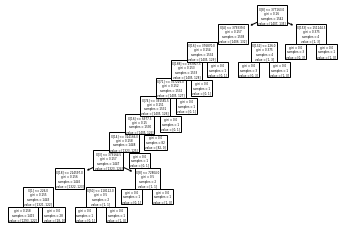

In [15]:
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.naive_bayes import MultinomialNB
clf_nb = MultinomialNB()
clf_nb.fit(X_train_indices,Y_train)
clf = tree.DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_train_indices,Y_train)
tree.plot_tree(clf)
svc = LinearSVC(random_state=1, dual=False)
svc.fit(X_train_indices,Y_train)
lr = LogisticRegression(solver='newton-cg', class_weight='balanced')
lr.fit(X_train_indices,Y_train)
pred_lr=lr.predict(X_test_indices)
pred_DT=clf.predict(X_test_indices)
pred_svc = svc.predict(X_test_indices)
pred_nb=clf_nb.predict(X_test_indices)

In [16]:
pred_tot=[sum(x) for x in zip(pred_lr,pred_DT,pred_svc,pred_nb)]
pred=[int(x>1) for x in pred_tot]


In [17]:
from sklearn.metrics import recall_score
recall_score(Y_test,pred, average='micro')

0.8864468864468864

In [18]:
from sklearn.metrics import precision_score
precision_score(Y_test ,pred, average='micro')

0.8864468864468864

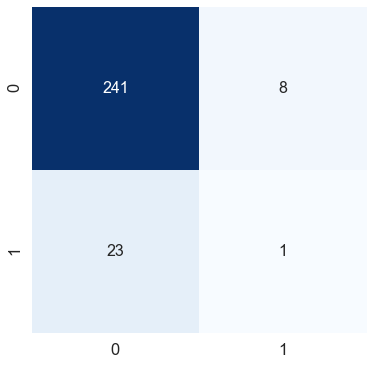

In [19]:
conf_matrix(Y_test,pred)

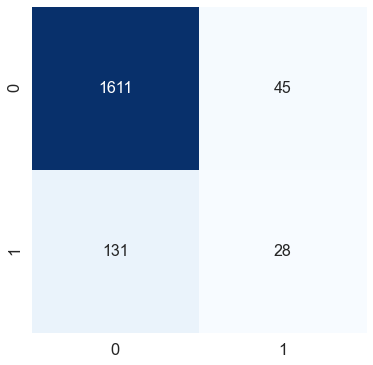

In [20]:
pred_lrw=lr.predict(X_indices)
pred_DTw=clf.predict(X_indices)
pred_svcw = svc.predict(X_indices)
pred_nbw=clf_nb.predict(X_indices)
pred_totw=[sum(x) for x in zip(pred_lrw,pred_DTw,pred_svcw,pred_nbw)]
predw=[int(x>1) for x in pred_totw]
conf_matrix(Y,predw)

In [21]:
import pickle
filename = 'model_nb.sav'
pickle.dump(clf_nb, open(filename, 'wb'))

In [22]:
import pickle
filename = 'model_dt.sav'
pickle.dump(clf, open(filename, 'wb'))

In [23]:
import pickle
filename = 'model_svc.sav'
pickle.dump(svc, open(filename, 'wb'))

In [24]:
import pickle
filename = 'model_lr.sav'
pickle.dump(svc, open(filename, 'wb'))

In [ ]:
################  Rough ######################

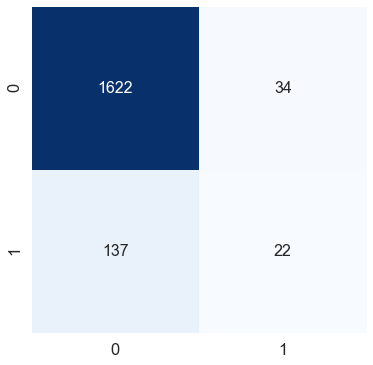

In [30]:
conf_matrix(Y,pred_DTw)

In [ ]:
from sklearn.metrics import recall_score
recall_score(Y_test,pred, average='micro')

In [ ]:
from sklearn.metrics import precision_score
precision_score(Y_test ,pred, average='micro')

In [ ]:
from sklearn.metrics import plot_confusion_matrix
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
plot_confusion_matrix(IC,pred, Y_test, normalize='true', values_format='.2%')  
plt.show()

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier(n_estimators=100, random_state=0)
adb.fit(X_train_indices,Y_train)
predictions_adb = adb.predict(X_test_indices)

In [ ]:

conf_matrix(Y_test,pred_nb)

In [ ]:
dat=pd.read_excel('./input/Linkedin_Posts.xlsx')

In [ ]:
dat.tail()

In [ ]:
x=dat['Content'].to_numpy()

In [ ]:
x_indices=sentences_to_indices(x, word_to_index,maxLen)

In [ ]:
pred_lrw=lr.predict(x_indices)
pred_DTw=clf.predict(x_indices)
pred_svcw = svc.predict(x_indices)
pred_nbw=clf_nb.predict(x_indices)
pred_totw=[sum(z) for z in zip(3*pred_lrw,pred_DTw,pred_svcw,pred_nbw)]
predw=[int(z>1) for z in pred_totw]

In [ ]:
for i